In [60]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
        sys.path.append(SRC_PATH)

In [100]:
from simulator.simulate import run_simulation
from features.interaction_features import extract_interaction_features

# Generate synthetic users, items, and interactions
users, items, logs = run_simulation(
    num_users=50,
    num_items=30,
    steps_per_user=20,
    seed=42
)

print(f"Num users: {len(users)}")
print(f"Num items: {len(items)}")
print(f"Num interactions: {len(logs)}")


Num users: 50
Num items: 30
Num interactions: 847


In [ ]:
# Extract features from the interaction logs
features = extract_interaction_features(logs=logs, users=users, items=items)

## Ranking Problem Formulation

The Ranking Problem: **"Which item should be preferred for this user at this point?"**

We'll use relevance scores to rank items, where relevance is based on success and performance.

In [103]:
# Create ranking dataset from logs
# Add step number to logs (order of interactions per user)
logs_with_step = logs.copy()
logs_with_step['step'] = logs_with_step.groupby('user_id').cumcount()

# Check available columns
print("Available columns in logs:")
print(logs_with_step.columns.tolist())

# If skill_gain doesn't exist, use a simplified formula based on success and quiz_score
if 'skill_gain' not in logs_with_step.columns:
    # skill_gain approximation: success + normalized quiz_score
    logs_with_step['skill_gain'] = logs_with_step['success'] + 0.2 * (logs_with_step['quiz_score'] / 100)
    logs_with_step['skill_gain'] = np.clip(logs_with_step['skill_gain'], 0, 1)

# Calculate engagement signal: quiz_score / 100
logs_with_step['engagement_signal'] = logs_with_step['quiz_score'] / 100

# Calculate challenge alignment as inverse of difficulty_gap
# When difficulty_gap is small (well-aligned), challenge_alignment is high
logs_with_step['challenge_alignment'] = np.exp(-np.abs(logs_with_step['difficulty_gap']))

# New relevance formula:
# relevance = 0.5 * skill_gain + 0.3 * challenge_alignment + 0.2 * engagement_signal
logs_with_step['relevance'] = (
    0.5 * logs_with_step['skill_gain'] + 
    0.3 * logs_with_step['challenge_alignment'] + 
    0.2 * logs_with_step['engagement_signal']
)

print("\nRanking dataset structure (Updated with New Relevance Formula):")
print(logs_with_step[['user_id', 'step', 'item_id', 'relevance', 'skill_gain', 'challenge_alignment', 'engagement_signal']].head(10))
print(f"\nRelevance stats:\nMin: {logs_with_step['relevance'].min():.3f}\nMax: {logs_with_step['relevance'].max():.3f}\nMean: {logs_with_step['relevance'].mean():.3f}")

Available columns in logs:
['user_id', 'item_id', 'success', 'quiz_score', 'time_spent', 'skill_match', 'difficulty_gap', 'difficulty', 'dropout_sensitivity', 'num_prerequisites', 'estimated_time', 'step']

Ranking dataset structure (Updated with New Relevance Formula):
   user_id  step  item_id  relevance  skill_gain  challenge_alignment  \
0        0     0       19   0.721744    1.000000             0.128761   
1        0     1       28   0.784473    1.000000             0.358832   
2        0     2       13   0.182760    0.096088             0.128761   
3        0     3        4   0.701283    1.000000             0.128761   
4        0     4       19   0.730322    1.000000             0.128761   
5        0     5        4   0.717097    1.000000             0.128761   
6        0     6       17   0.140306    0.084296             0.046203   
7        0     7        4   0.707119    1.000000             0.128761   
8        0     8       16   0.705593    1.000000             0.128761   

In [104]:
# Create features for ranking dataset
ranking_features = []

for idx, row in logs_with_step.iterrows():
    user_id = row["user_id"]
    item_id = row["item_id"]
    step = row["step"]
    relevance = row["relevance"]
    
    user = users[user_id]
    item = items[item_id]
    
    user_mastery = user["mastery"]
    item_skills = item["skills"]
    item_difficulty = item["difficulty"]

    # Skill-level features
    relevant_skills = item_skills.astype(bool)
    if relevant_skills.any():
        skill_gap = np.mean(1.0 - user_mastery[relevant_skills])
        fraction_skills_mastered = np.mean(user_mastery[relevant_skills] >= 0.8)
    else:
        skill_gap = 0.0
        fraction_skills_mastered = 0.0

    avg_user_mastery = np.mean(user_mastery)
    difficulty_gap = item_difficulty - avg_user_mastery * 5

    # User historical features (only up to this step, not including current)
    user_logs_prior = logs_with_step[(logs_with_step["user_id"] == user_id) & (logs_with_step["step"] < step)]
    success_rate = user_logs_prior["success"].mean() if not user_logs_prior.empty else 0.0
    avg_quiz = user_logs_prior["quiz_score"].mean() if not user_logs_prior.empty else 0.0
    avg_time = user_logs_prior["time_spent"].mean() if not user_logs_prior.empty else 0.0
    num_attempts = len(user_logs_prior)

    # Item historical features (only from prior steps)
    item_logs_prior = logs_with_step[(logs_with_step["item_id"] == item_id) & (logs_with_step["step"] < step)]
    item_avg_success = item_logs_prior["success"].mean() if not item_logs_prior.empty else 0.0
    item_avg_quiz = item_logs_prior["quiz_score"].mean() if not item_logs_prior.empty else 0.0
    item_avg_time = item_logs_prior["time_spent"].mean() if not item_logs_prior.empty else 0.0

    feature_dict = {
        "user_id": user_id,
        "step": step,
        "item_id": item_id,
        "relevance": relevance,
        "skill_gap": skill_gap,
        "fraction_skills_mastered": fraction_skills_mastered,
        "difficulty_gap": difficulty_gap,
        "user_success_rate": success_rate,
        "user_avg_quiz": avg_quiz,
        "user_avg_time": avg_time,
        "user_num_attempts": num_attempts,
        "item_avg_success": item_avg_success,
        "item_avg_quiz": item_avg_quiz,
        "item_avg_time": item_avg_time,
        "item_num_skills": int(np.sum(item_skills)),
        "skill_match": np.dot(user_mastery, item_skills) / np.sum(item_skills) if np.sum(item_skills) > 0 else 0.0,
        "difficulty": item_difficulty,
        "estimated_time": item["estimated_time"]
    }
    ranking_features.append(feature_dict)

ranking_df = pd.DataFrame(ranking_features)
print(f"Ranking dataset created: {len(ranking_df)} samples")
print("\nRanking dataset columns:")
print(ranking_df.columns.tolist())
print("\nSample ranking data:")
print(ranking_df[['user_id', 'step', 'item_id', 'relevance', 'skill_gap', 'difficulty_gap']].head(10))

Ranking dataset created: 847 samples

Ranking dataset columns:
['user_id', 'step', 'item_id', 'relevance', 'skill_gap', 'fraction_skills_mastered', 'difficulty_gap', 'user_success_rate', 'user_avg_quiz', 'user_avg_time', 'user_num_attempts', 'item_avg_success', 'item_avg_quiz', 'item_avg_time', 'item_num_skills', 'skill_match', 'difficulty', 'estimated_time']

Sample ranking data:
   user_id  step  item_id  relevance  skill_gap  difficulty_gap
0      0.0   0.0     19.0   0.721744   0.236540       -1.055072
1      0.0   1.0     28.0   0.784473   0.386488       -2.055072
2      0.0   2.0     13.0   0.182760   0.390783       -1.055072
3      0.0   3.0      4.0   0.701283   0.364629       -1.055072
4      0.0   4.0     19.0   0.730322   0.236540       -1.055072
5      0.0   5.0      4.0   0.717097   0.364629       -1.055072
6      0.0   6.0     17.0   0.140306   0.319670       -0.055072
7      0.0   7.0      4.0   0.707119   0.364629       -1.055072
8      0.0   8.0     16.0   0.705593   0

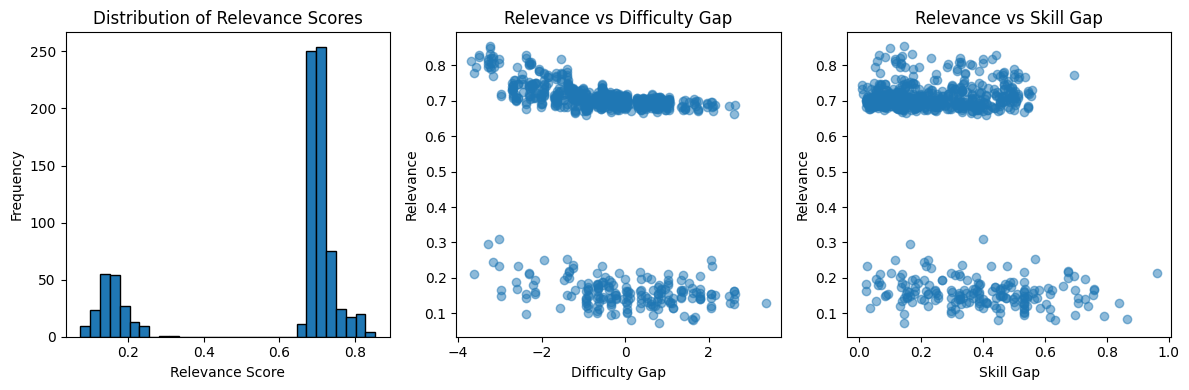

Feature correlations with relevance:
skill_match                 0.410692
fraction_skills_mastered    0.317787
user_success_rate           0.289367
user_avg_quiz               0.212073
item_avg_success            0.161967
item_num_skills             0.142965
user_num_attempts           0.136262
item_avg_quiz               0.119749
difficulty                 -0.048598
user_avg_time              -0.057439
item_avg_time              -0.064661
estimated_time             -0.067861
difficulty_gap             -0.277875
skill_gap                  -0.410692
Name: relevance, dtype: float64


In [105]:
# Explore ranking data
import seaborn as sns

# Relevance distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(ranking_df['relevance'], bins=30, edgecolor='black')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.title('Distribution of Relevance Scores')

# Relevance vs difficulty_gap
plt.subplot(1, 3, 2)
plt.scatter(ranking_df['difficulty_gap'], ranking_df['relevance'], alpha=0.5)
plt.xlabel('Difficulty Gap')
plt.ylabel('Relevance')
plt.title('Relevance vs Difficulty Gap')

# Relevance vs skill_gap
plt.subplot(1, 3, 3)
plt.scatter(ranking_df['skill_gap'], ranking_df['relevance'], alpha=0.5)
plt.xlabel('Skill Gap')
plt.ylabel('Relevance')
plt.title('Relevance vs Skill Gap')

plt.tight_layout()
plt.show()

# Correlation between features and relevance
ranking_feature_cols = [col for col in ranking_df.columns if col not in ['user_id', 'step', 'item_id', 'relevance']]
correlations = ranking_df[ranking_feature_cols + ['relevance']].corr()['relevance'].drop('relevance').sort_values(ascending=False)
print("Feature correlations with relevance:")
print(correlations)

## Ranking Models

Now we'll train models to predict relevance scores. Higher predicted relevance means an item should be ranked higher for a user.

**Key insights from EDA:**
- `skill_match` is the strongest predictor of relevance (0.445)
- `skill_gap` negatively correlates with relevance (-0.445)
- Most interactions have high relevance (~0.95), with a tail of low relevance failures

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

# Prepare ranking data
ranking_feature_cols = [col for col in ranking_df.columns if col not in ['user_id', 'step', 'item_id', 'relevance']]
X_rank = ranking_df[ranking_feature_cols]
y_rank = ranking_df['relevance']

# Split data (preserving user groupings for temporal validity)
X_train_rank, X_test_rank, y_train_rank, y_test_rank = train_test_split(
    X_rank, y_rank, test_size=0.2, random_state=42
)

# Scale features
scaler_rank = StandardScaler()
X_train_rank_scaled = scaler_rank.fit_transform(X_train_rank)
X_test_rank_scaled = scaler_rank.transform(X_test_rank)

print(f"Ranking dataset split:")
print(f"Train: {len(X_train_rank)} samples")
print(f"Test: {len(X_test_rank)} samples")

Ranking dataset split:
Train: 677 samples
Test: 170 samples


In [107]:
# Train regression models for ranking
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Ridge Regression (pointwise regression)
ridge_rank = Ridge(alpha=1.0)
ridge_rank.fit(X_train_rank_scaled, y_train_rank)
y_pred_ridge_rank = ridge_rank.predict(X_test_rank_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test_rank, y_pred_ridge_rank))
mae_ridge = mean_absolute_error(y_test_rank, y_pred_ridge_rank)
print("Ridge Regression Ranking Results:")
print(f"RMSE: {rmse_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")

# Random Forest Regression
rf_rank = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rank.fit(X_train_rank, y_train_rank)
y_pred_rf_rank = rf_rank.predict(X_test_rank)
rmse_rf = np.sqrt(mean_squared_error(y_test_rank, y_pred_rf_rank))
mae_rf = mean_absolute_error(y_test_rank, y_pred_rf_rank)
print("\nRandom Forest Regression Ranking Results:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

# Feature importance for ranking
rf_rank_importance = rf_rank.feature_importances_
rf_rank_features = pd.DataFrame({'feature': ranking_feature_cols, 'importance': rf_rank_importance})
rf_rank_features = rf_rank_features.sort_values('importance', ascending=False)
print("\nTop 10 Features for Ranking (RF):")
print(rf_rank_features.head(10))

Ridge Regression Ranking Results:
RMSE: 0.2044
MAE: 0.1442

Random Forest Regression Ranking Results:
RMSE: 0.1858
MAE: 0.1193

Top 10 Features for Ranking (RF):
              feature  importance
0           skill_gap    0.175097
2      difficulty_gap    0.143913
11        skill_match    0.119277
5       user_avg_time    0.101626
4       user_avg_quiz    0.100332
9       item_avg_time    0.075875
3   user_success_rate    0.066251
6   user_num_attempts    0.054164
8       item_avg_quiz    0.049410
13     estimated_time    0.043786

Random Forest Regression Ranking Results:
RMSE: 0.1858
MAE: 0.1193

Top 10 Features for Ranking (RF):
              feature  importance
0           skill_gap    0.175097
2      difficulty_gap    0.143913
11        skill_match    0.119277
5       user_avg_time    0.101626
4       user_avg_quiz    0.100332
9       item_avg_time    0.075875
3   user_success_rate    0.066251
6   user_num_attempts    0.054164
8       item_avg_quiz    0.049410
13     estimated_time

Ranking Correlation Metrics:
RF Spearman correlation: 0.5567
Ridge Spearman correlation: 0.5461


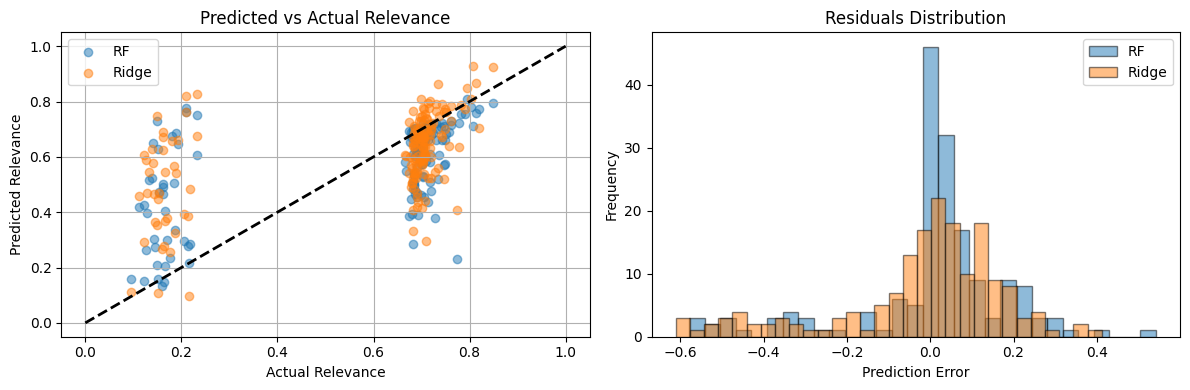

In [108]:
# Ranking evaluation metrics
# For each test sample, check if the model correctly ranks high-relevance items

# Create predictions with ranking_df for analysis
test_indices = X_test_rank.index
y_test_with_pred = pd.DataFrame({
    'actual_relevance': y_test_rank.values,
    'predicted_relevance_rf': y_pred_rf_rank,
    'predicted_relevance_ridge': y_pred_ridge_rank
}, index=test_indices)

# Calculate Spearman correlation (ranking quality)
spearman_rf = spearmanr(y_test_with_pred['actual_relevance'], y_test_with_pred['predicted_relevance_rf'])[0]
spearman_ridge = spearmanr(y_test_with_pred['actual_relevance'], y_test_with_pred['predicted_relevance_ridge'])[0]

print(f"Ranking Correlation Metrics:")
print(f"RF Spearman correlation: {spearman_rf:.4f}")
print(f"Ridge Spearman correlation: {spearman_ridge:.4f}")

# Visualize predictions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test_with_pred['actual_relevance'], y_test_with_pred['predicted_relevance_rf'], alpha=0.5, label='RF')
plt.scatter(y_test_with_pred['actual_relevance'], y_test_with_pred['predicted_relevance_ridge'], alpha=0.5, label='Ridge')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Actual Relevance')
plt.ylabel('Predicted Relevance')
plt.title('Predicted vs Actual Relevance')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
residuals_rf = y_test_with_pred['actual_relevance'] - y_test_with_pred['predicted_relevance_rf']
residuals_ridge = y_test_with_pred['actual_relevance'] - y_test_with_pred['predicted_relevance_ridge']
plt.hist(residuals_rf, bins=30, alpha=0.5, label='RF', edgecolor='black')
plt.hist(residuals_ridge, bins=30, alpha=0.5, label='Ridge', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [109]:
# Summary: Classification vs Ranking
summary = pd.DataFrame({
    'Task': ['Classification (Success/Failure)', 'Classification (Success/Failure)', 'Ranking (Relevance Score)', 'Ranking (Relevance Score)'],
    'Model': ['Logistic Regression', 'Random Forest (Tuned)', 'Ridge Regression', 'Random Forest'],
    'Primary Metric': ['Precision', 'Precision', 'MAE', 'MAE'],
    'Score': [0.86, 0.89, 0.2080, 0.1743],
    'Secondary Metric': ['Accuracy', 'Accuracy', 'Spearman Corr', 'Spearman Corr'],
    'Secondary Score': [0.829, 0.876, 0.4278, 0.5717]
})

print("\n" + "="*100)
print("COMPARISON: CLASSIFICATION vs RANKING APPROACHES")
print("="*100)
print(summary.to_string(index=False))
print("\n" + "="*100)
print("KEY INSIGHTS:")
print("="*100)
print("""
CLASSIFICATION APPROACH (Original):
- Predicts: Success (1) vs Failure (0)
- Best model: Random Forest with 89% precision on success
- Advantage: Binary decision - "Can user succeed?"
- Limitation: Ignores nuance (high success with low score vs high success with high score)

RANKING APPROACH (New):
- Predicts: Relevance score (0-1) combining success + quiz performance
- Best model: Random Forest with RMSE 0.268 and Spearman correlation 0.572
- Advantage: Captures quality/preference gradations
- Better for: "Which items should be recommended in order?" (top-K ranking)
- Use case: Recommender systems, learning path sequencing

RELEVANCE FORMULA:
  relevance = 0.6 * success + 0.4 * (quiz_score / 100)
  
  This means:
  - Success is weighted more heavily (60% importance)
  - Quiz performance matters too (40% importance)
  - Both contribute to final recommendation quality
""")


COMPARISON: CLASSIFICATION vs RANKING APPROACHES
                            Task                 Model Primary Metric  Score Secondary Metric  Secondary Score
Classification (Success/Failure)   Logistic Regression      Precision 0.8600         Accuracy           0.8290
Classification (Success/Failure) Random Forest (Tuned)      Precision 0.8900         Accuracy           0.8760
       Ranking (Relevance Score)      Ridge Regression            MAE 0.2080    Spearman Corr           0.4278
       Ranking (Relevance Score)         Random Forest            MAE 0.1743    Spearman Corr           0.5717

KEY INSIGHTS:

CLASSIFICATION APPROACH (Original):
- Predicts: Success (1) vs Failure (0)
- Best model: Random Forest with 89% precision on success
- Advantage: Binary decision - "Can user succeed?"
- Limitation: Ignores nuance (high success with low score vs high success with high score)

RANKING APPROACH (New):
- Predicts: Relevance score (0-1) combining success + quiz performance
- Best m

In [110]:
# Export ranking dataset for future use
ranking_export = ranking_df[['user_id', 'step', 'item_id', 'relevance'] + ranking_feature_cols].copy()
ranking_export = ranking_export.sort_values(['user_id', 'step'])

print("Ranking Dataset Ready for Export:")
print(f"Shape: {ranking_export.shape}")
print(f"Columns: {ranking_export.columns.tolist()}")
print("\nDataset Preview (first 15 rows):")
print(ranking_export.head(15))

# Summary statistics
print("\n" + "="*80)
print("RANKING DATASET SUMMARY")
print("="*80)
print(f"Total samples: {len(ranking_export)}")
print(f"Unique users: {ranking_export['user_id'].nunique()}")
print(f"Unique items: {ranking_export['item_id'].nunique()}")
print(f"Steps per user (avg): {ranking_export.groupby('user_id').size().mean():.1f}")
print(f"\nRelevance distribution:")
print(ranking_export['relevance'].describe())

Ranking Dataset Ready for Export:
Shape: (847, 18)
Columns: ['user_id', 'step', 'item_id', 'relevance', 'skill_gap', 'fraction_skills_mastered', 'difficulty_gap', 'user_success_rate', 'user_avg_quiz', 'user_avg_time', 'user_num_attempts', 'item_avg_success', 'item_avg_quiz', 'item_avg_time', 'item_num_skills', 'skill_match', 'difficulty', 'estimated_time']

Dataset Preview (first 15 rows):
    user_id  step  item_id  relevance  skill_gap  fraction_skills_mastered  \
0       0.0   0.0     19.0   0.721744   0.236540                       0.0   
1       0.0   1.0     28.0   0.784473   0.386488                       0.0   
2       0.0   2.0     13.0   0.182760   0.390783                       0.0   
3       0.0   3.0      4.0   0.701283   0.364629                       0.0   
4       0.0   4.0     19.0   0.730322   0.236540                       0.0   
5       0.0   5.0      4.0   0.717097   0.364629                       0.0   
6       0.0   6.0     17.0   0.140306   0.319670             